# 월간 데이콘 법원 판결 예측 AI 경진대회
특정 사건에서 첫 번째 당사자와 두 번째 당사자 중 첫 번째 당사자의 승소 여부를 예측
https://dacon.io/competitions/official/236112/overview/description
- ID : 사건 샘플 ID
- first_party : 사건의 첫 번째 당사자
- second_party : 사건의 두 번째 당사자
- facts : 사건 내용
- first_party_winner : 첫 번째 당사자의 승소 여부 (0 : 패배, 1 : 승리)

+++ 비교해 확인
https://dacon.io/competitions/official/235671/codeshare/2006?page=1&dtype=recent

## 라이브러리 및 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import nltk # 문장 토크나이저
#nltk.download('punkt')

# 영어 불용어 - 불용어 모아 놓은 리스트 다운로드해 제거
nltk.download('all')
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize # 토큰화
from nltk.stem.porter import PorterStemmer # 어근 동일화 <-> 이거 말고도 "Lancaster Stemmer"

# 표제어 추출
from nltk.stem import WordNetLemmatizer

# 정규표현 처리
import re

In [ ]:
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 불용어(분석에 필요없는 토큰) 제거
    no_stops = [word for word in no_capitals if not word in stops]

    # 어근 추츨을 통한 텍스트 정규화 작업
    stemmer_words = [stemmer.stem(word) for word in no_stops]
    return ' '.join(stemmer_words)

In [ ]:
# 구글 드라이브에서 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile

# ZIP 파일 열기
with zipfile.ZipFile('/content/gdrive/MyDrive/0000/dacon_lawwinner/open.zip', 'r') as zip_ref:
    # 파일 목록 가져오기
    file_list = zip_ref.namelist()

    # 파일 목록 출력
    for file in file_list:
        print(file)

    # 모든 파일 압축 해제
    zip_ref.extractall()

sample_submission.csv
test.csv
train.csv


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

### 토크나이저 (기본base)


● Sentence Tokenization
마침표나 느낌표, 물음표 등으로 구분
마침표의 경우 항상 문장의 마지막이 아니라 Mr. / Dr. 등등 문장 중간에도 들어갈 수 있음. 그러나 영어 문장의 경우 이러한 케이스도 잘 잡아주고 있는 것을 확인

- 좋은 vocab을 만드는 것이 곧 토크나이징 퀄리티와 직결
- 모델이 맥락 지식을 잘 학습하여 downstream task에서 좋은 성능을 내는 데에까지 영향
- 모델 학습에 들어가기에 앞서 vocab을 잘 살펴볼 필요

In [ ]:
train['facts_lst'] = 0 # 문장 토큰화
train['facts_word'] = 0 # 단어 토큰화

for i in range(2478):
  train.facts_lst[i] = nltk.sent_tokenize(train.facts[i])
  train.facts_word[i] = word_tokenize(train.facts[i])

In [ ]:
train.head(5)

,ID,first_party,second_party,facts,first_party_winner,facts_lst,facts_word
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"[On June 27, 1962, Phil St. Amant, a candidate...","[On, June, 27, ,, 1962, ,, Phil, St., Amant, ,..."
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,[Ramon Nelson was riding his bike when he suff...,"[Ramon, Nelson, was, riding, his, bike, when, ..."
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,[An Alabama state court convicted Billy Joe Ma...,"[An, Alabama, state, court, convicted, Billy, ..."
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,[Victor Linkletter was convicted in state cour...,"[Victor, Linkletter, was, convicted, in, state..."
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"[On April 24, 1953 in Selma, Alabama, an intru...","[On, April, 24, ,, 1953, in, Selma, ,, Alabama..."


## EDA

### Base

In [ ]:
train.isnull().sum()

ID                    0
first_party           0
second_party          0
facts                 0
first_party_winner    0
facts_lst             0
facts_word            0
dtype: int64

In [ ]:
# 동명이인 일까
# 아님 동일한 사람의 기록일까
train.describe(include=object)

,ID,first_party,second_party,facts,facts_lst,facts_word
count,2478,2478,2478,2478,2478,2478
unique,2478,2110,1974,2478,2478,2478
top,TRAIN_0000,United States,United States,"On June 27, 1962, Phil St. Amant, a candidate ...","[On June 27, 1962, Phil St. Amant, a candidate...","[On, June, 27, ,, 1962, ,, Phil, St., Amant, ,..."
freq,1,154,240,1,1,1


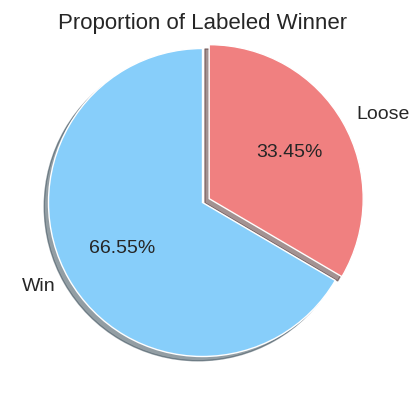

1    1649
0     829
Name: first_party_winner, dtype: int64


In [ ]:
# set the figure size
plt.figure(figsize=(9, 5))

# set the style
plt.style.use('seaborn-darkgrid')

# set the colors
colors = ['lightskyblue', 'lightcoral']

# generate a pie plot
plt.pie(train['first_party_winner'].value_counts(), explode=(0, 0.05), labels=["Win", "Loose"],
        autopct="%0.2f%%", textprops={'fontsize': 14}, shadow=True, startangle=90, colors=colors)

# add a title
plt.title('Proportion of Labeled Winner', size=16, y=0.93)

# show the plot
plt.show()

# 승소 값 확인
print(train['first_party_winner'].value_counts())

### party 확인

<Axes: title={'center': 'first_party'}>

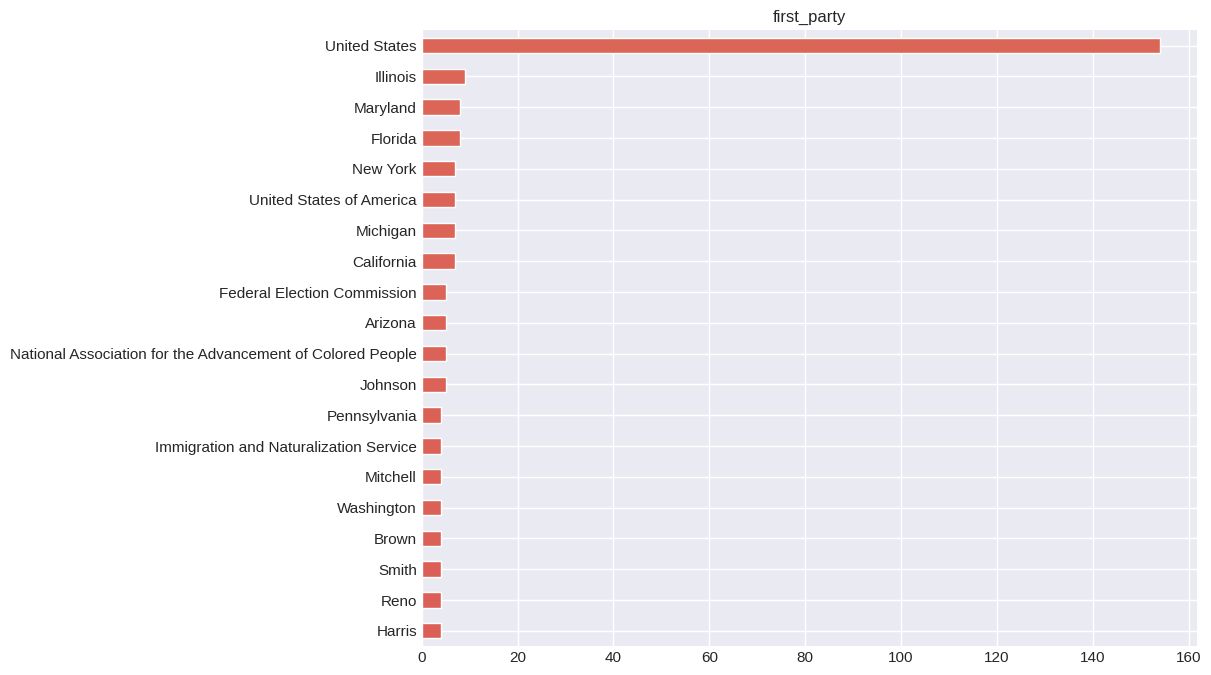

In [ ]:
first = train["first_party"].value_counts().head(20)
colors = sns.color_palette('hls',len(train['first_party'].unique()))
first = first.sort_values(ascending=True)
first.plot.barh(figsize=(10,8), title="first_party", color=colors)

<Axes: title={'center': 'second_party'}>

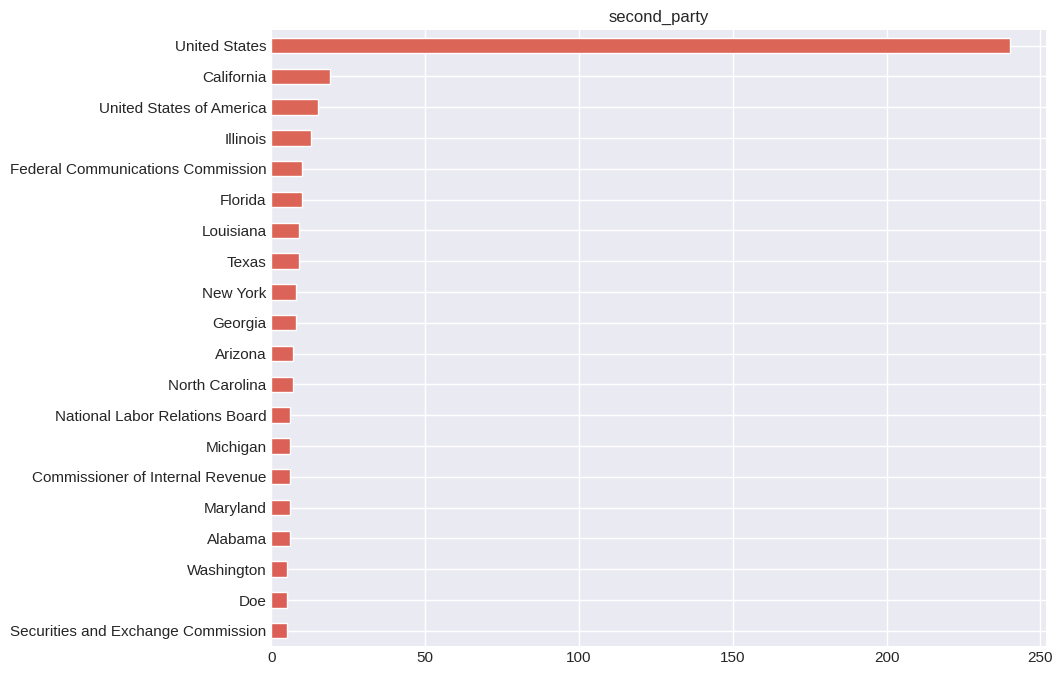

In [ ]:
second = train["second_party"].value_counts().head(20)
colors = sns.color_palette('hls',len(train['second_party'].unique()))
second = second.sort_values(ascending=True)
second.plot.barh(figsize=(10,8), title="second_party", color=colors)

### 문장 및 단어 수 시각화

In [ ]:
# set the random state
random_state = 4041

# import the wordcloud library
from wordcloud import WordCloud

# concat all the text for each labels
win_facts = [''.join(t) for t in train[train['first_party_winner']==1]['facts']]
win_strings = ' '.join(map(str, win_facts))
loose_text = [''.join(t) for t in train[train['first_party_winner']==0]['facts']]
loose_strings = ' '.join(map(str, loose_text))

# generate word clouds
win_cloud = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(win_strings)
loose_cloud = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(loose_strings)

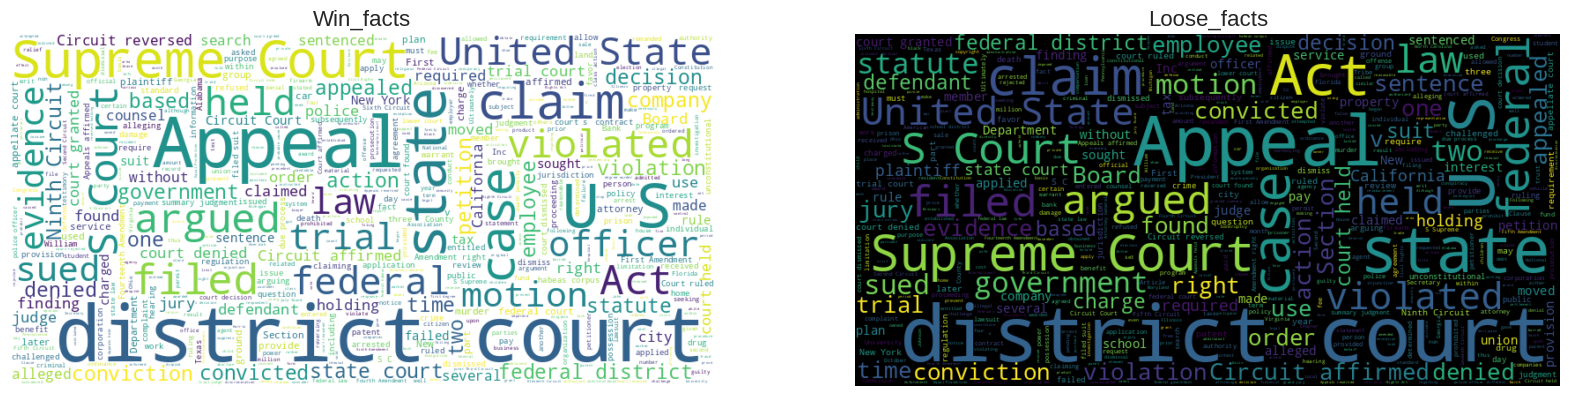

In [ ]:
# create subplots for the generated clouds
fig, axes = plt.subplots(1, 2, figsize = (20,20))
axes[0].imshow(win_cloud, interpolation='bilinear')
axes[1].imshow(loose_cloud, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes]

# add titles
axes[0].set_title('Win_facts', fontsize=16)
axes[1].set_title('Loose_facts', fontsize=16)

# show the figure
plt.show()

In [ ]:
# 제일 많이 등장하는 문장
win_word = list(train[train.first_party_winner == 1].facts_lst) # 첫번째 party win
loose_word = list(train[train.first_party_winner == 0].facts_lst) # 첫번째 party loose
ww_list = []
lw_list = []

for i in win_word:
  ww_list = ww_list + i

for i in loose_word:
  lw_list = lw_list + i


from nltk import Text # Text(토큰리스트, [name=이름])
ww_text = Text(ww_list, name="win")
lw_text = Text(lw_list, name="loose")

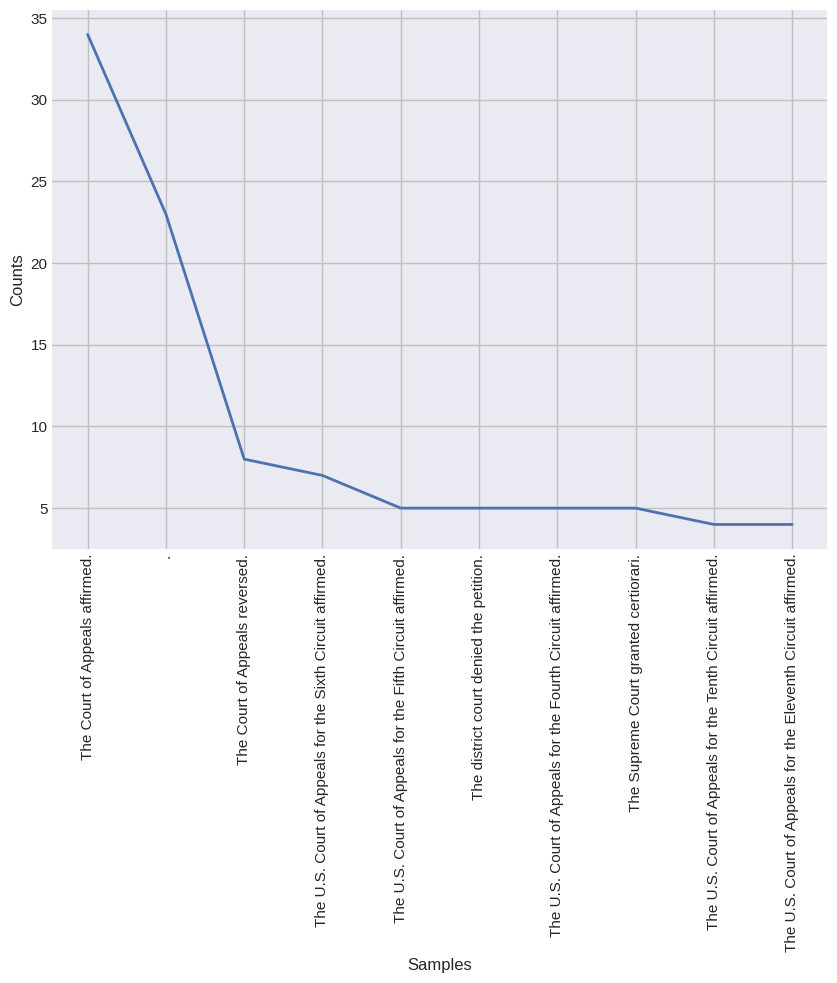

In [ ]:
plt.figure(figsize=(10,7))
ww_text.plot(10)
plt.show()

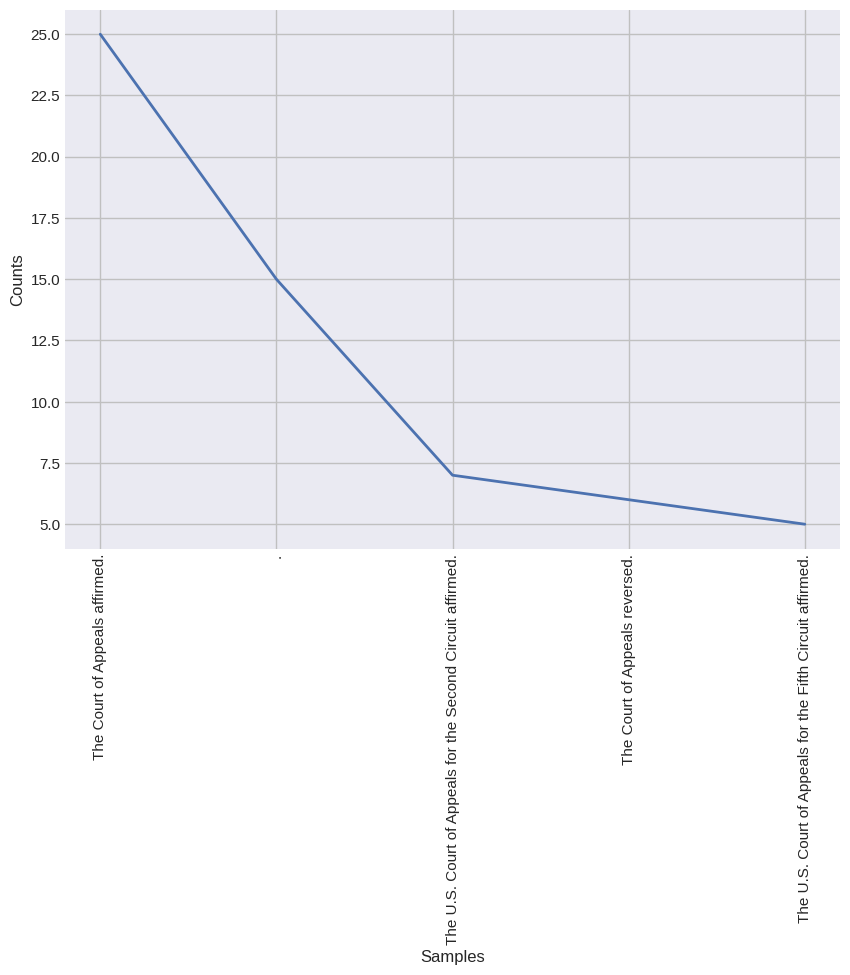

In [ ]:
plt.figure(figsize=(10,7))
lw_text.plot(5)
plt.show()

######### win

- The Court of Appeals affirmed
- .
- The Court of Appeals reversed
- The U.S. Court of Appeals for the Sixth Circuit affirmed.
- The U.S. Court of Appeals for the Fifth Circuit affirmed.
- The distinct court denied the petition
- The U.S. Court of Appeals for the Fourth Circuit affirmed.
- The Supreme Court granted certiorari.
- The U.S. Court of Appeals for the Tenth Circuit affirmed.
- The U.S. Court of Appeals for the Elevneth Circuit affirmed.


########## loose

- The Court of Appeals affirmed
- .
- The U.S. Court of Appeals for the Second Circuit affirmed.
- The Court of Appeals reversed
- The U.S. Court of Appeals for the Fifth Circuit affirmed.

In [ ]:
# 단어별 확인 https://tech-diary.tistory.com/11

# make noun frequency graph per religion
def make_top_word_graph( result, top ):
    result = cleaning(result)
    tokens = result.split(" ") # 문자열을 공백 기준으로 구분
    text = nltk.Text(tokens) # nltk
    topWord = text.vocab().most_common(top) # top n word
    count = 30 # top word on graph
    xlist = [a[0] for a in topWord[:count ]]
    ylist = [a[1] for a in topWord[:count ]]

    plt.figure(0)
 #   font_name = font_manager.FontProperties(fname='./font/font.ttf', size=7).get_name()
 #   rc('font', family=font_name) # 한글 적용

    plt.xlabel('Word')
    plt.xticks(rotation=70) # x축 라벨 회전
    plt.ylabel('Count')
    plt.title('keyword' +' TOP '+str(count)+' WORD')
    plt.ylim([10, 7000]) # y축 범위 (최대값을 기준으로 동일하게 설정하기 위함)
    plt.plot(xlist,ylist)
    # plt.savefig('top-word-graph.png', dpi=400)
    return

In [ ]:
win_word = list(train[train.first_party_winner == 1].facts_lst) # 첫번째 party win
loose_word = list(train[train.first_party_winner == 0].facts_lst) # 첫번째 party loose
ww_list = []
lw_list = []

for i in loose_word:
  lw_list = lw_list + i

for i in win_word:
  ww_list = ww_list + i

# 각 로우별 문장 모두 문자열 합치기
ww_list = " ".join(ww_list)
lw_list = " ".join(lw_list)

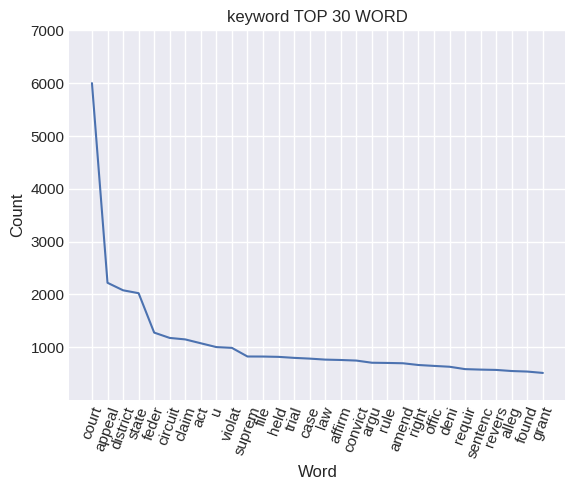

In [ ]:
make_top_word_graph(ww_list, 30)

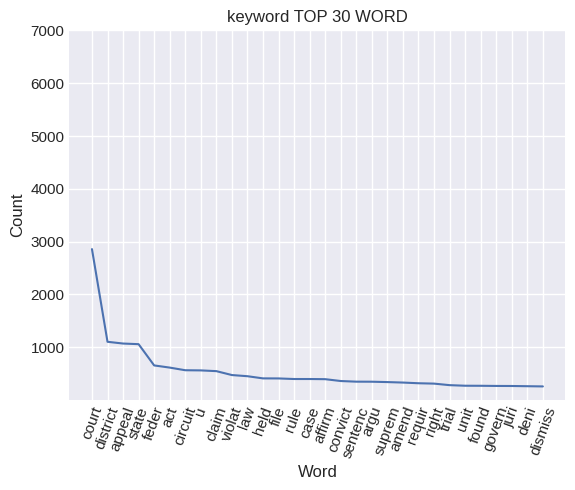

In [ ]:
make_top_word_graph(lw_list, 30)

### 의미없는 중복되는 문장

In [ ]:
def non_meaning(str):
    replaceAll = str
    sentence_str = 'The U.S. Court of Appeals for the'
    # 빈도수 많이 나오는 공통 어구(일치하는 문자) 제거
    ## https://heytech.tistory.com/38
    ## https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-5%EC%9D%BC%EC%B0%A8-70b1d773d30a
    test = re.sub(pattern = sentence_str, repl = " ",	string = replaceAll)
    return test

In [ ]:
train_df = train[['first_party','second_party','facts','first_party_winner']]
train_df['fact_processing'] = train_df['facts'].apply(non_meaning)
train_df = train_df[['first_party','second_party','fact_processing','first_party_winner']]

train_df['facts_lst'] = 0 # 문장 토큰화
train_df['facts_word'] = 0 # 단어 토큰화

for i in range(2478):
  train_df.facts_lst[i] = nltk.sent_tokenize(train_df.fact_processing[i])
  train_df.facts_word[i] = word_tokenize(train_df.fact_processing[i])

train_df.head(5)

,first_party,second_party,fact_processing,first_party_winner,facts_lst,facts_word
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"[On June 27, 1962, Phil St. Amant, a candidate...","[On, June, 27, ,, 1962, ,, Phil, St., Amant, ,..."
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,[Ramon Nelson was riding his bike when he suff...,"[Ramon, Nelson, was, riding, his, bike, when, ..."
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,[An Alabama state court convicted Billy Joe Ma...,"[An, Alabama, state, court, convicted, Billy, ..."
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,[Victor Linkletter was convicted in state cour...,"[Victor, Linkletter, was, convicted, in, state..."
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"[On April 24, 1953 in Selma, Alabama, an intru...","[On, April, 24, ,, 1953, in, Selma, ,, Alabama..."


In [ ]:
# 제일 많이 등장하는 문장
win_word = list(train_df[train_df.first_party_winner == 1].facts_lst) # 첫번째 party win
loose_word = list(train_df[train_df.first_party_winner == 0].facts_lst) # 첫번째 party loose
ww_list = []
lw_list = []

for i in win_word:
  ww_list = ww_list + i

for i in loose_word:
  lw_list = lw_list + i


from nltk import Text # Text(토큰리스트, [name=이름])
ww_text = Text(ww_list, name="win")
lw_text = Text(lw_list, name="loose")

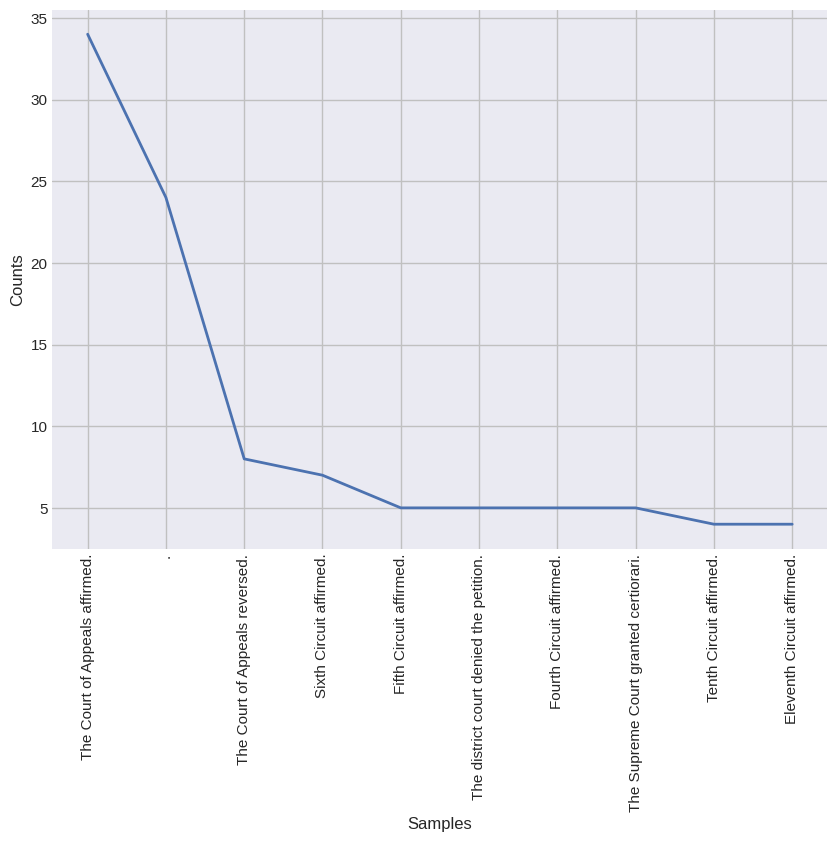

In [ ]:
plt.figure(figsize=(10,7))
ww_text.plot(10)
plt.show()

### word_lst 에 제거

In [95]:
train_t2 = train[['ID', 'first_party', 'second_party','facts_lst','first_party_winner']]
train_t2.head(5)

,ID,first_party,second_party,facts_lst,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"[On June 27, 1962, Phil St. Amant, a candidate...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,[Ramon Nelson was riding his bike when he suff...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",[An Alabama state court convicted Billy Joe Ma...,1
3,TRAIN_0003,Linkletter,Walker,[Victor Linkletter was convicted in state cour...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"[On April 24, 1953 in Selma, Alabama, an intru...",1


In [97]:
train_t2.facts_lst

0       [On June 27, 1962, Phil St. Amant, a candidate...
1       [Ramon Nelson was riding his bike when he suff...
2       [An Alabama state court convicted Billy Joe Ma...
3       [Victor Linkletter was convicted in state cour...
4       [On April 24, 1953 in Selma, Alabama, an intru...
                              ...                        
2473    [Congress amended the Clean Air Act through th...
2474    [Alliance Bond Fund, Inc., an investment fund,...
2475    [In 1992, the District Court sentenced Manuel ...
2476    [On March 8, 1996, Enrico St. Cyr, a lawful pe...
2477    [Herbert Markman owns the patent to a system t...
Name: facts_lst, Length: 2478, dtype: object

In [99]:
train_t2.facts_lst[1]

['Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat.',
 'After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death.',
 'Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.',
 'Owens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial.',
 'He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense.',
 'The district court denied the writ of habeas corpus, and Owens appealed.',
 'The U.S. Court of Appeals

In [88]:
def non_meaning(str):
    replaceAll = str
    sentence_str = 'The U.S. Court of Appeals for the'
    test = re.sub("The U.S. Court of Appeals for the|affirmed", "", str)
    return test

In [89]:
train_df = train[['first_party','second_party','facts','first_party_winner']]
train_df['fact_processing'] = train_df['facts'].apply(non_meaning)
train_df = train_df[['first_party','second_party','fact_processing','first_party_winner']]

train_df['facts_lst'] = 0 # 문장 토큰화
train_df['facts_word'] = 0 # 단어 토큰화

for i in range(2478):
  train_df.facts_lst[i] = nltk.sent_tokenize(train_df.fact_processing[i])
  train_df.facts_word[i] = word_tokenize(train_df.fact_processing[i])

train_df.head(5)

,first_party,second_party,fact_processing,first_party_winner,facts_lst,facts_word
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"[On June 27, 1962, Phil St. Amant, a candidate...","[On, June, 27, ,, 1962, ,, Phil, St., Amant, ,..."
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,[Ramon Nelson was riding his bike when he suff...,"[Ramon, Nelson, was, riding, his, bike, when, ..."
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,[An Alabama state court convicted Billy Joe Ma...,"[An, Alabama, state, court, convicted, Billy, ..."
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,[Victor Linkletter was convicted in state cour...,"[Victor, Linkletter, was, convicted, in, state..."
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"[On April 24, 1953 in Selma, Alabama, an intru...","[On, April, 24, ,, 1953, in, Selma, ,, Alabama..."


In [90]:
train_df.fact_processing[1]

'Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed.  Seventh Circuit reversed the denial and held tha

In [85]:
def non_meaning(str):
    replaceAll = str
    sentence_str = 'The U.S. Court of Appeals for the'
    test = str.replace(sentence_str,'')
    return test

In [86]:
train_df = train[['first_party','second_party','facts','first_party_winner']]
train_df['fact_processing'] = train_df['facts'].apply(non_meaning)
train_df = train_df[['first_party','second_party','fact_processing','first_party_winner']]

train_df['facts_lst'] = 0 # 문장 토큰화
train_df['facts_word'] = 0 # 단어 토큰화

for i in range(2478):
  train_df.facts_lst[i] = nltk.sent_tokenize(train_df.fact_processing[i])
  train_df.facts_word[i] = word_tokenize(train_df.fact_processing[i])

train_df.head(5)

,first_party,second_party,fact_processing,first_party_winner,facts_lst,facts_word
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"[On June 27, 1962, Phil St. Amant, a candidate...","[On, June, 27, ,, 1962, ,, Phil, St., Amant, ,..."
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,[Ramon Nelson was riding his bike when he suff...,"[Ramon, Nelson, was, riding, his, bike, when, ..."
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,[An Alabama state court convicted Billy Joe Ma...,"[An, Alabama, state, court, convicted, Billy, ..."
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,[Victor Linkletter was convicted in state cour...,"[Victor, Linkletter, was, convicted, in, state..."
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"[On April 24, 1953 in Selma, Alabama, an intru...","[On, April, 24, ,, 1953, in, Selma, ,, Alabama..."


In [87]:
train_df.fact_processing[1]

'Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed.  Seventh Circuit reversed the denial and held tha

In [83]:
def non_meaning(str):
    replaceAll = str
    #sentence_str1 = 'The U.S. Court of Appeals for the'
    #test = re.sub(pattern = (sentence_str1), repl = " ",	string = replaceAll)
    sentence_str = 'The U.S. Court of Appeals for the'
    test = re.findall(sentence_str,	string = replaceAll)
    return test

In [84]:
train_df = train[['first_party','second_party','facts','first_party_winner']]
train_df['fact_processing'] = train_df['facts'].apply(non_meaning)
train_df = train_df[['first_party','second_party','fact_processing','first_party_winner']]

train_df['facts_lst'] = 0 # 문장 토큰화
train_df['facts_word'] = 0 # 단어 토큰화

for i in range(2478):
  train_df.facts_lst[i] = nltk.sent_tokenize(train_df.fact_processing[i])
  train_df.facts_word[i] = word_tokenize(train_df.fact_processing[i])

train_df.head(5)

TypeError: ignored

In [82]:
train_df.fact_processing[1]

'Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed. The U.S. Court of Appeals for the Seventh Circuit

In [ ]:
# set the random state
random_state = 4041

# import the wordcloud library
from wordcloud import WordCloud

# concat all the text for each labels
win_facts = [''.join(t) for t in train_df[train_df['first_party_winner']==1]['fact_processing']]
win_strings = ' '.join(map(str, win_facts))
loose_text = [''.join(t) for t in train_df[train_df['first_party_winner']==0]['fact_processing']]
loose_strings = ' '.join(map(str, loose_text))

# generate word clouds
win_cloud = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(win_strings)
loose_cloud = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(loose_strings)

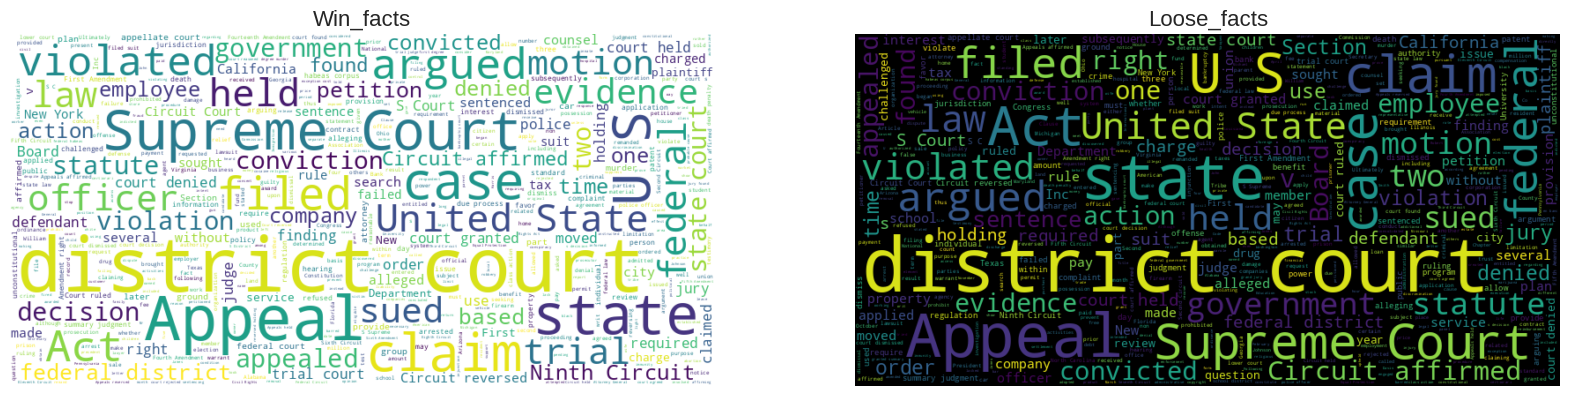

In [ ]:
# create subplots for the generated clouds
fig, axes = plt.subplots(1, 2, figsize = (20,20))
axes[0].imshow(win_cloud, interpolation='bilinear')
axes[1].imshow(loose_cloud, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes]

# add titles
axes[0].set_title('Win_facts', fontsize=16)
axes[1].set_title('Loose_facts', fontsize=16)

# show the figure
plt.show()

### 원고/피고 확인

In [71]:
import nltk
nltk.download('wordnet')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [72]:
# 원고 first_party_winner
wordnet.synsets('defendant')

[Synset('defendant.n.01')]

In [73]:
wordnet.synsets('plaintiff')

[Synset('plaintiff.n.01')]

In [ ]:
train[train.facts.str.contains('defendant')].facts[4]

'On April 24, 1953 in Selma, Alabama, an intruder broke into the apartment of the daughter of the city mayor. The daughter and the intruder struggled through several rooms until she was able to seize his knife, and he fled. The assailant had a towel over his head, so the victim could not identify the defendant during the trial. The police apprehended William Earl Fikes on the basis of a call from a private citizen and held him “on an open charge of investigation.” The police questioned Fikes for hours, placed him in jail, and limited his access to anyone familiar. After nearly a week of this treatment, Fikes confessed in the form of answers to the interrogator’s leading questions. Five days later, Fikes confessed under questioning a second time. When these confessions were admitted into the trial as evidence, Fikes did not testify regarding the events surrounding his interrogation because the judge had ruled he would be subjected to unlimited cross-examination. The jury convicted Fikes

In [ ]:
train[train.facts.str.contains('plaintiff')]

,ID,first_party,second_party,facts,first_party_winner,facts_lst,facts_word
6,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,[Sections of the Immigration and Nationality A...,"[Sections, of, the, Immigration, and, National..."
13,TRAIN_0013,"James Obergefell, et al.","Richard Hodges, Director of the Ohio Departmen...",Groups of same-sex couples sued their relevant...,1,[Groups of same-sex couples sued their relevan...,"[Groups, of, same-sex, couples, sued, their, r..."
14,TRAIN_0014,"James J. Thole, et al.","U.S. Bank, N.A., et al.",Named plaintiff James Thole and others brought...,0,[Named plaintiff James Thole and others brough...,"[Named, plaintiff, James, Thole, and, others, ..."
33,TRAIN_0033,Gerald T. Martin et ux.,"Franklin Capital Corporation, et al.",The Martins filed a class action lawsuit again...,0,[The Martins filed a class action lawsuit agai...,"[The, Martins, filed, a, class, action, lawsui..."
35,TRAIN_0035,Caterpillar Inc.,Lewis,"Asserting state law claims, Lewis, a Kentucky ...",1,"[Asserting state law claims, Lewis, a Kentucky...","[Asserting, state, law, claims, ,, Lewis, ,, a..."
...,...,...,...,...,...,...,...
2424,TRAIN_2424,"American Electric Power Company Inc., et al.","Connecticut, et al.","Eight states, New York City and three land con...",1,"[Eight states, New York City and three land co...","[Eight, states, ,, New, York, City, and, three..."
2431,TRAIN_2431,"Edmund Gerald Brown, Governor, et al.","Entertainment Merchants Association, et al.","Associations of companies that create, publish...",0,"[Associations of companies that create, publis...","[Associations, of, companies, that, create, ,,..."
2440,TRAIN_2440,"Intel Corporation Investment Policy Committee,...",Christopher M. Sulyma,"In 2015, Christopher Sulyma, a former Intel em...",0,"[In 2015, Christopher Sulyma, a former Intel e...","[In, 2015, ,, Christopher, Sulyma, ,, a, forme..."
2448,TRAIN_2448,Pennsylvania,Delaware Valley Citizens' Council for Clean Air,"In April of 1973, pursuant to the Clean Air Ac...",1,"[In April of 1973, pursuant to the Clean Air A...","[In, April, of, 1973, ,, pursuant, to, the, Cl..."


In [ ]:
train[train.facts.str.contains('banana')]

,ID,first_party,second_party,facts,first_party_winner,facts_lst,facts_word
1141,TRAIN_1141,Sentilles,Inter-Caribbean Shipping Corporation,"In April of 1953, Daniel J. Sentilles, an engi...",1,"[In April of 1953, Daniel J. Sentilles, an eng...","[In, April, of, 1953, ,, Daniel, J., Sentilles..."


In [100]:
train[train.facts.str.contains('court')]

,ID,first_party,second_party,facts,first_party_winner,facts_lst,facts_word
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"[On June 27, 1962, Phil St. Amant, a candidate...","[On, June, 27, ,, 1962, ,, Phil, St., Amant, ,..."
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,[Ramon Nelson was riding his bike when he suff...,"[Ramon, Nelson, was, riding, his, bike, when, ..."
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,[An Alabama state court convicted Billy Joe Ma...,"[An, Alabama, state, court, convicted, Billy, ..."
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,[Victor Linkletter was convicted in state cour...,"[Victor, Linkletter, was, convicted, in, state..."
6,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,[Sections of the Immigration and Nationality A...,"[Sections, of, the, Immigration, and, National..."
...,...,...,...,...,...,...,...
2471,TRAIN_2471,United States,James X. Bormes,"In October 2000, the United States Treasury De...",1,"[In October 2000, the United States Treasury D...","[In, October, 2000, ,, the, United, States, Tr..."
2472,TRAIN_2472,United States,Cuauhtemoc Gonzalez-Lopez,"Cuauhtemoc Gonzalez-Lopez hired Joseph Low, an...",0,"[Cuauhtemoc Gonzalez-Lopez hired Joseph Low, a...","[Cuauhtemoc, Gonzalez-Lopez, hired, Joseph, Lo..."
2475,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",0,"[In 1992, the District Court sentenced Manuel ...","[In, 1992, ,, the, District, Court, sentenced,..."
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",0,"[On March 8, 1996, Enrico St. Cyr, a lawful pe...","[On, March, 8, ,, 1996, ,, Enrico, St., Cyr, ,..."
